# But du fichier

L'objectif de ce notebook est de rassembler les pokemon par archétype de statistique (plutôt offensif, plutôt défensif, équilibré, ...) puis d'étudier la viabilité de chaque archétype (en calculant la moyenne d'usage sur le cluster par exemple).

## Packages


In [92]:
import numpy as np # Pour des calculs mathématiques
import pandas as pd # Pour la manipulation de tableaux de données
import matplotlib.pyplot as plt # Pour les graphiques

from scipy.cluster.hierarchy import dendrogram # Pour le dendrogramme
from sklearn.preprocessing import StandardScaler # Pour la normalisation des données
from sklearn.cluster import AgglomerativeClustering # Pour la CAH
from sklearn.cluster import KMeans # Pour les K-means

import sqlite3 
conn = sqlite3.connect('STNUM_pokemon.db') #Outil permettant d'exploiter la base de donnée


In [93]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

## Importation des données


In [94]:
repert = 'stats_pokemons/'
stats = pd.read_table(repert + 'Pokemon.csv', sep=',')
stats = stats[stats['Can_Evolve'] == 0]
print(stats)

        ID          Name Form     Type1     Type2  Total   HP  Attack  \
2        3      Venusaur          Grass    Poison    525   80      82   
5        6     Charizard           Fire    Flying    534   78      84   
8        9     Blastoise          Water              530   79      83   
11      12    Butterfree            Bug    Flying    395   60      45   
14      15      Beedrill            Bug    Poison    395   65      90   
...    ...           ...  ...       ...       ...    ...  ...     ...   
1189  1006  Iron Valiant          Fairy  Fighting    590   74     130   
1190  1007      Koraidon       Fighting    Dragon    670  100     135   
1191  1008      Miraidon       Electric    Dragon    670  100      85   
1192  1009  Walking Wake          Water    Dragon    590   99      83   
1193  1010   Iron Leaves          Grass   Psychic    590   90     130   

      Defense  Sp. Atk  Sp. Def  Speed  Generation  Can_Evolve  
2          83      100      100     80           1       F

### Reshaping data


In [95]:
def conc_name_form(df):
    col = []
    for i in range(len(df['Name'])):
        if df['Form'].iloc[i] is not None:
            col.append(df['Name'].iloc[i] + df['Form'].iloc[i])
        else:
            col.append(df['Name'].iloc[i])
    df.insert(df.columns.get_loc('Name'), 'NameForm', col, True)
    df = df.drop(['Name','Form'], axis=1)
    return df

stats = conc_name_form(stats)
stats.head()


,ID,NameForm,Type1,Type2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Can_Evolve
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
5,6,Charizard,Fire,Flying,534,78,84,78,109,85,100,1,False
8,9,Blastoise,Water,,530,79,83,100,85,105,78,1,False
11,12,Butterfree,Bug,Flying,395,60,45,50,90,80,70,1,False
14,15,Beedrill,Bug,Poison,395,65,90,40,45,80,75,1,False


In [116]:
stats.index = stats['NameForm']
stats = stats.drop('NameForm', axis=1)
stats

,ID,Type1,Type2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Can_Evolve
NameForm,,,,,,,,,,,,
Venusaur,3,Grass,Poison,525,80,82,83,100,100,80,1,False
Charizard,6,Fire,Flying,534,78,84,78,109,85,100,1,False
Blastoise,9,Water,,530,79,83,100,85,105,78,1,False
Butterfree,12,Bug,Flying,395,60,45,50,90,80,70,1,False
Beedrill,15,Bug,Poison,395,65,90,40,45,80,75,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...
Iron Valiant,1006,Fairy,Fighting,590,74,130,90,120,60,116,9,False
Koraidon,1007,Fighting,Dragon,670,100,135,115,85,100,135,9,False
Miraidon,1008,Electric,Dragon,670,100,85,100,135,115,135,9,False


In [117]:
data_cluster_stats = stats.drop(['Type1', 'Type2', 'ID', 'Can_Evolve', 'Generation'], axis = 1)
data_cluster_stats.head()

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
NameForm,,,,,,,
Venusaur,525,80,82,83,100,100,80
Charizard,534,78,84,78,109,85,100
Blastoise,530,79,83,100,85,105,78
Butterfree,395,60,45,50,90,80,70
Beedrill,395,65,90,40,45,80,75


In [118]:
n = data_cluster_stats.shape[0]
p = data_cluster_stats.shape[1]
print(n, p)

711 7


Puis on normalise les données :

In [119]:
norm = StandardScaler(with_mean=True, with_std=True)
data_cluster_stats = norm.fit_transform(data_cluster_stats)
data_cluster_stats

array([[ 0.06442357, -0.10695746, -0.47692947, ...,  0.40032766,
         0.5813889 , -0.03771062],
       [ 0.17786506, -0.18662928, -0.40884457, ...,  0.68329428,
        -0.01781023,  0.63259565],
       [ 0.12744662, -0.14679337, -0.44288702, ..., -0.07128335,
         0.78112194, -0.10474125],
       ...,
       [ 1.89209212,  0.68976075, -0.37480211, ...,  1.50075337,
         1.18058803,  1.80563162],
       [ 0.88372326,  0.64992484, -0.44288702, ...,  1.18634603,
        -0.09770345,  0.93423347],
       [ 0.88372326,  0.29140164,  1.15710816, ..., -0.54289437,
         0.90096177,  0.7666569 ]])

# CAH avec la méthode de Ward


In [120]:
cah_model = AgglomerativeClustering(distance_threshold=0,
                                       metric='euclidean',
                                       linkage='ward',
                                       n_clusters=None)
cah = cah_model.fit(data_cluster_stats)   

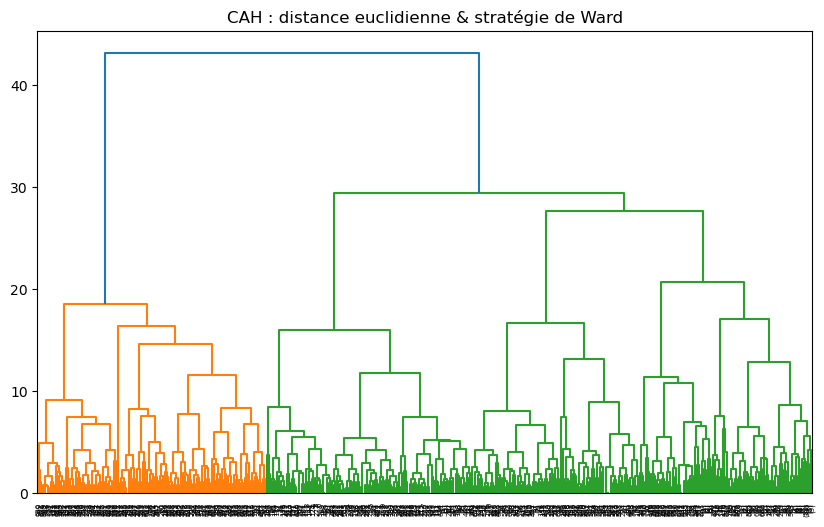

In [122]:
plt.subplots(figsize=(10, 6))
plt.title('CAH : distance euclidienne & stratégie de Ward')
# plot the top three levels of the dendrogram
plot_dendrogram(cah, truncate_mode="level", p=10)
plt.show()

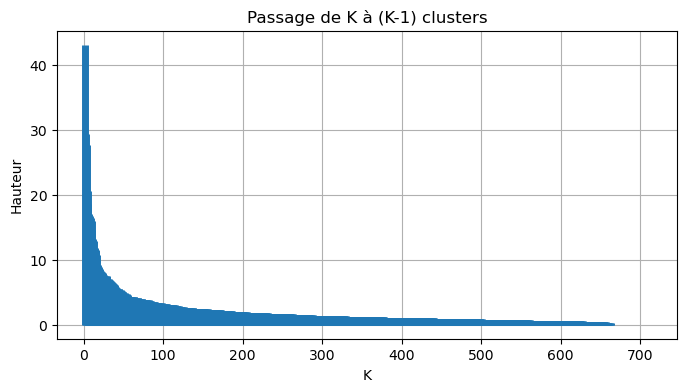

In [123]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.vlines(range(2, n+1), 0, np.flip(np.sort(cah.distances_)), linewidth=5)
ax.grid()
ax.set_xlabel('K')
ax.set_ylabel('Hauteur')
plt.title('Passage de K à (K-1) clusters')
plt.show()

On zoome sur la partie qui nous intéresse (saut de hauteur) :


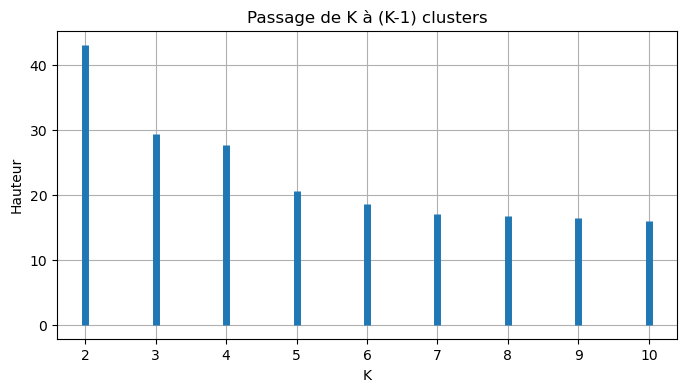

In [125]:
k_max = 10

fig, ax = plt.subplots(figsize=(8, 4))
ax.vlines(range(2, k_max+1), 0, np.flip(np.sort(cah.distances_))[0:k_max-1], linewidth=5)
ax.set_xticks(range(2, k_max+1))
ax.grid()
ax.set_xlabel('K')
ax.set_ylabel('Hauteur')
plt.title('Passage de K à (K-1) clusters')
plt.show()

On peut choisir entre 3 et 6 clusters. On choisit k = 3 clusters :

In [126]:
k = 3

cah_model = AgglomerativeClustering(metric='euclidean',
                                   linkage='ward',
                                   n_clusters=k)
cah = cah_model.fit(data_cluster_stats)

stats['cluster_cah_ward'] = cah.fit_predict(data_cluster_stats)
stats['cluster_cah_ward'].value_counts()

0    367
2    174
1    170
Name: cluster_cah_ward, dtype: int64

On peut ensuite réaliser une K-means avec le nombre de clusters obtenu par la CAH.

In [127]:
kmeans_model = KMeans(init='k-means++', max_iter=100, n_clusters=k, n_init=10)
kmeans = kmeans_model.fit(data_cluster_stats)

stats['cluster_kmeans'] = kmeans.fit_predict(data_cluster_stats)
stats['cluster_kmeans'].value_counts()

c:\Users\tidiane\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\tidiane\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


1    276
2    266
0    169
Name: cluster_kmeans, dtype: int64

In [128]:
for i in range(k):
    print('\n', 'Cluster', i)
    print(list(stats[stats['cluster_kmeans'] == i].index))


 Cluster 0
['Arcanine ', 'Articuno ', 'Zapdos ', 'Moltres ', 'Dragonite ', 'Mewtwo ', 'Mew ', 'Raikou ', 'Entei ', 'Tyranitar ', 'Lugia ', 'Ho-oh ', 'Celebi ', 'Slaking ', 'Salamence ', 'Metagross ', 'Latias ', 'Latios ', 'Kyogre ', 'Groudon ', 'Rayquaza ', 'Jirachi ', 'DeoxysNormal Forme', 'DeoxysAttack Forme', 'DeoxysSpeed Forme', 'Garchomp ', 'Magmortar ', 'Mesprit ', 'Azelf ', 'Dialga ', 'Palkia ', 'Heatran ', 'Regigigas ', 'GiratinaAltered Forme', 'GiratinaOrigin Forme', 'Manaphy ', 'Darkrai ', 'ShayminLand Forme', 'ShayminSky Forme', 'Arceus ', 'Victini ', 'Archeops ', 'Hydreigon ', 'Volcarona ', 'Cobalion ', 'Terrakion ', 'Virizion ', 'TornadusIncarnate Forme', 'TornadusTherian Forme', 'ThundurusIncarnate Forme', 'ThundurusTherian Forme', 'Reshiram ', 'Zekrom ', 'LandorusIncarnate Forme', 'LandorusTherian Forme', 'Kyurem ', 'KyuremWhite Kyurem', 'KyuremBlack Kyurem', 'KeldeoOrdinary Form', 'KeldeoResolute Form', 'MeloettaAria Forme', 'MeloettaPirouette Forme', 'Genesect ', 'Ven

On observe que les pokemon ayant un total de statistiques très élevé se retrouvent dans le cluster 0. Ceux dans le cluster 1 sont des pokemon à la répartition statistique équilibrée, voire orientée sur la défensive (PV et défenses élevées). Ceux dans le cluster 2 sont ceux ayant des statistiques offensives élevées (attaques et vitesse).

On essaie avec 6 clusters :

In [132]:
k = 6

cah_model = AgglomerativeClustering(metric='euclidean',
                                   linkage='ward',
                                   n_clusters=k)
cah = cah_model.fit(data_cluster_stats)

stats['cluster_cah_ward'] = cah.fit_predict(data_cluster_stats)
stats['cluster_cah_ward'].value_counts()

2    174
0    163
1    131
3    113
4     73
5     57
Name: cluster_cah_ward, dtype: int64

In [133]:
kmeans_model = KMeans(init='k-means++', max_iter=100, n_clusters=k, n_init=10)
kmeans = kmeans_model.fit(data_cluster_stats)

stats['cluster_kmeans'] = kmeans.fit_predict(data_cluster_stats)
stats['cluster_kmeans'].value_counts()

c:\Users\tidiane\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


c:\Users\tidiane\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


1    173
5    136
3    127
0    125
2     91
4     59
Name: cluster_kmeans, dtype: int64

In [134]:
for i in range(k):
    print('\n', 'Cluster', i)
    print(list(stats[stats['cluster_kmeans'] == i].index))


 Cluster 0
['Venusaur ', 'Blastoise ', 'Clefable ', 'Vileplume ', 'Tentacruel ', 'Slowbro ', 'Dewgong ', 'Hypno ', 'Mr. Mime ', 'Omastar ', 'Articuno ', 'Meganium ', 'Noctowl ', 'Ampharos ', 'Bellossom ', 'Politoed ', 'Sunflora ', 'Umbreon ', 'Slowking ', 'Shuckle ', 'Magcargo ', 'Corsola ', 'Mantine ', 'Hitmontop ', 'Suicune ', 'Ludicolo ', 'Pelipper ', 'Gardevoir ', 'Grumpig ', 'Altaria ', 'Lunatone ', 'Claydol ', 'Cradily ', 'Milotic ', 'Kecleon ', 'Chimecho ', 'Gorebyss ', 'Regice ', 'Registeel ', 'DeoxysDefense Forme', 'Empoleon ', 'Roserade ', 'Bastiodon ', 'WormadamPlant Cloak', 'WormadamTrash Cloak', 'Vespiquen ', 'Mismagius ', 'Bronzong ', 'Spiritomb ', 'Magnezone ', 'Togekiss ', 'Glaceon ', 'Probopass ', 'Dusknoir ', 'RotomHeat Rotom', 'RotomWash Rotom', 'RotomFrost Rotom', 'RotomFan Rotom', 'RotomMow Rotom', 'Uxie ', 'Cresselia ', 'Musharna ', 'DarmanitanZen Mode', 'Scrafty ', 'Cofagrigus ', 'Gothitelle ', 'Jellicent ', 'Beheeyem ', 'Chandelure ', 'Cryogonal ', 'AmpharosMeg




Le cluster 0 comporte les Pokemon très défensifs (PV et défenses élevées).

Le cluster 1 comporte des Pokémon aux statistiques faibles.

Le cluster 2 comporte les Pokémon orientés sur les statistiques spéciales (Attaque et défense).


Le cluster 3 comporte des Pokémon ayant de bonnes statistiques offensives et défensives, mais lents (vitesse faible). On les appelle des Tanks.

Le cluster 4 comporte les Pokémon avec beaucoup de total de statistiques. Ce sont en général des Pokémon légendaires ou pseudo-légendaires.

Le cluster 5 comporte les Pokémon puissants et rapides (Attaques et vitesse élevées), mais fragiles (défenses et PV faibles). Ce sont des Pokémon offensifs.

Désormais nous allons voir quelles classes de pokémon sont les plus utilisées en stratégie, en calculant l'usage moyen au sein d'un cluster.

# Récupération des données d'usage

In [153]:
conn_stats = sqlite3.connect('stats_pokemons/stats_pokemons.db')
request = "SELECT * FROM 'Pokemons usage'"
df_usage = pd.read_sql(request, conn_stats)
df_usage.index = df_usage['name_pokemon']
df_usage = df_usage.drop('name_pokemon', axis=1)
df_usage.head()

,usage
name_pokemon,
Magnemite,0.000130
Iron Leaves,0.004438
Zoroark,0.001976
Arboliva,0.005741
Iron Valiant,0.236758


In [156]:
print(len(df_usage.index))

310


On ajoute désormais les usages des pokémon à la table de stats établie précédemment. 

Cependant, certains Pokémon ne sont plus présents dans le jeu depuis la génération 8. Nous avons donc décidé d'attribuer à chaque Pokémon son usage dans la génération la plus récente où il était disponible.

In [ ]:
def add_usage_all_gens_col(df): 
    col = []
    for i in range(df.index.count()):
        if df['Form'].iloc[i] is not None:
            col.append(df['Name'].iloc[i] + df['Form'].iloc[i])
        else:
            col.append(df['Name'].iloc[i])
    df.insert(df.columns.get_loc('Name'), 'NameForm', col, True)
    df = df.drop(['Name','Form'], axis=1)
    return df

stats = conc_name_form(stats)
stats.head()